## Redundancy and Correlation

In preparation for a principal component analysis, we look at redundancy and correlation in our dataset. In this analysis, we will focus on the numeric features.

In [1]:
source('src/load_data-02.r')
source('src/multiplot.r')

In [2]:
dim(housing_df)

[1] 1451   80

In [3]:
head(housing_df)

MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,⋯,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
60,RL,65,8450,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,⋯,0,without,without,without,0,2,2008,WD,Normal,208500
20,RL,80,9600,Reg,Lvl,AllPub,FR2,Gtl,Veenker,⋯,0,without,without,without,0,5,2007,WD,Normal,181500
60,RL,68,11250,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,⋯,0,without,without,without,0,9,2008,WD,Normal,223500
70,RL,60,9550,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,⋯,0,without,without,without,0,2,2006,WD,Abnorml,140000
60,RL,84,14260,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,⋯,0,without,without,without,0,12,2008,WD,Normal,250000
50,RL,85,14115,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,⋯,0,without,MnPrv,Shed,700,10,2009,WD,Normal,143000


In [4]:
count_empty_total()

In [5]:
numeric_features = colnames(Filter(is.numeric, housing_df))

In [6]:
numeric_df = Filter(is.numeric, housing_df)
numeric_df$SalePrice <- NULL
numeric_features = colnames(numeric_df)

In [7]:
attach(numeric_df)

In [8]:
install.packages('rpart')

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [9]:
library(caret)
library(rpart)

Loading required package: lattice


### Redundancy

Here, we use machine learning to assess redundancy in our dataset. We iterate through each numeric feature in our dataset. For each feature, we dropped the feature from our input/featureet $X$ And use it as our target $y$ for the training of a supervised regression model. In this case, we use the shortcut for training a model on all features, `~.`, as our regression formula

    this_formula = paste(feature,"~.")
    fit <- rpart(data=train, formula=as.formula(this_formula))
    
In other words we are training a regression model where we use the remaining features to protect each individual feature. We will thus have an $R^2$ score for each numeric feature. Note,  that the `rpart` function is available as part of the `caret` library in R. This is the implementation of a decision tree. 

Note, that we also use machine learning best practices and perform a train–test split on our data. Each model is trained using the training data and assessed using the testing data. In this way, each model tells us if, upon removing a feature, the remaining features are able to predict the removed feature. If the remaining features are able to make this prediction, we may take the removed feature to be somewhat redundant. It is worth clarifying that this is an exploratory data analysis technique, and is not intended to be used at this time as a technique for removing features. We simply wish to understand the relationships within our data.

In [10]:
calculate_r_2 <- function(actual, prediction) {
    return (1 - (sum((actual-prediction)^2)/sum((actual-mean(actual))^2)))
}

calculate_r_2_for_feature <- function(data, feature) {
    n <- nrow(data)
    
    train_index <- sample(seq_len(n), size = 0.8*n)

    train <- data[train_index,]
    test <- data[-train_index,]
    
    this_formula = paste(feature,"~.")
    fit <- rpart(data=train, formula=as.formula(this_formula))

    y_test <- as.vector(test[[feature]])
    test[feature] <- NULL
    predictions <- predict(fit, test)
    return (calculate_r_2(y_test, predictions))
}

mean_r2_for_feature <- function (data, feature) {
    scores = c()
    for (i in 1:10) {
        scores = c(scores, calculate_r_2_for_feature(data, feature))
    }
    
    return (mean(scores))
}

In [11]:
calculate_r_2_for_feature(numeric_df,'LotFrontage')

[1] 0.347114

In [12]:
for (feature in numeric_features){
    print(paste(feature, mean_r2_for_feature(numeric_df, feature)))
}

[1] "LotFrontage 0.324421644157402"
[1] "LotArea -0.528147437046712"
[1] "YearBuilt 0.708350383039224"
[1] "YearRemodAdd 0.428617549946195"
[1] "MasVnrArea 0.18095244552509"
[1] "BsmtFinSF1 0.803959176496318"
[1] "BsmtFinSF2 0.387078970506263"
[1] "BsmtUnfSF 0.806469012514282"
[1] "TotalBsmtSF 0.647480962525038"
[1] "FirstFlrSF 0.766490532277561"
[1] "SecondFlrSF 0.87795579721457"
[1] "LowQualFinSF -0.709911815993187"
[1] "GrLivArea 0.852629617677604"
[1] "GarageYrBlt 0.775386007898649"
[1] "GarageArea 0.581737841067015"
[1] "WoodDeckSF 0.0554546622880636"
[1] "OpenPorchSF -0.00549856978961937"
[1] "EnclosedPorch 0.0843437449143098"
[1] "ThreeSsnPorch -0.323789412806441"
[1] "ScreenPorch -0.117972985190303"
[1] "PoolArea -Inf"
[1] "MiscVal -1.80381746899222"
[1] "YrSold 0.0572819386249845"


### Correlation

Next, we assess correlation between our features. Correlation is a function of covariance data, which is itself a measure of linear relationships within data. In the previous section, we use a decision tree to assess redundancy. A decision tree is an information-based (non-linear) analysis. By performing this analysis using two different techniques, one linear and one non-linear, we have a more robust assessment have the underlying relationships in our data. Again, this technique is exploratory data analysis and is not intended at this time to remove features from our dataset.

In [13]:
options(digits=3)
cor(numeric_df)

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,FirstFlrSF,⋯,GarageYrBlt,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,ThreeSsnPorch,ScreenPorch,PoolArea,MiscVal,YrSold
LotFrontage,1.00000,0.30692,0.11731,0.08231,0.17977,0.21720,0.04369,0.11997,0.3632,0.41515,⋯,0.06376,0.3234,0.07603,0.13526,0.01014,0.062581,0.0380,0.18135,0.001244,0.00767
LotArea,0.30692,1.00000,0.01571,0.01519,0.10414,0.21308,0.11167,-0.00425,0.2585,0.29598,⋯,-0.02403,0.1808,0.17317,0.08628,-0.02311,0.020568,0.0435,0.07789,0.038221,-0.01297
YearBuilt,0.11731,0.01571,1.00000,0.59032,0.31634,0.25021,-0.04761,0.15022,0.3943,0.28565,⋯,0.77906,0.4789,0.22696,0.18576,-0.38675,0.032145,-0.0490,0.00537,-0.033994,-0.01456
YearRemodAdd,0.08231,0.01519,0.59032,1.00000,0.18014,0.12842,-0.06649,0.18222,0.2930,0.24346,⋯,0.61582,0.3711,0.20751,0.22414,-0.19219,0.046012,-0.0375,0.00620,-0.009866,0.03526
MasVnrArea,0.17977,0.10414,0.31634,0.18014,1.00000,0.26447,-0.07244,0.11430,0.3637,0.34425,⋯,0.25072,0.3730,0.15975,0.12546,-0.11036,0.018752,0.0614,0.01170,-0.029854,-0.00815
BsmtFinSF1,0.21720,0.21308,0.25021,0.12842,0.26447,1.00000,-0.04950,-0.49660,0.5201,0.44284,⋯,0.14988,0.2954,0.20545,0.10728,-0.10589,0.026926,0.0631,0.14136,0.003852,0.01697
BsmtFinSF2,0.04369,0.11167,-0.04761,-0.06649,-0.07244,-0.04950,1.00000,-0.20981,0.1061,0.09865,⋯,-0.08571,-0.0176,0.06768,0.00416,0.03668,-0.030211,0.0884,0.04160,0.004784,0.03188
BsmtUnfSF,0.11997,-0.00425,0.15022,0.18222,0.11430,-0.49660,-0.20981,1.00000,0.4159,0.31805,⋯,0.18734,0.1839,-0.00418,0.13005,-0.00379,0.020825,-0.0126,-0.03517,-0.023884,-0.04034
TotalBsmtSF,0.36315,0.25854,0.39428,0.29299,0.36367,0.52010,0.10609,0.41590,1.0000,0.81811,⋯,0.31336,0.4863,0.23442,0.24441,-0.10038,0.037867,0.0856,0.12685,-0.018345,-0.01131
FirstFlrSF,0.41515,0.29598,0.28565,0.24346,0.34425,0.44284,0.09865,0.31805,0.8181,1.00000,⋯,0.22940,0.4908,0.23882,0.21023,-0.07290,0.056838,0.0902,0.13267,-0.021003,-0.00897


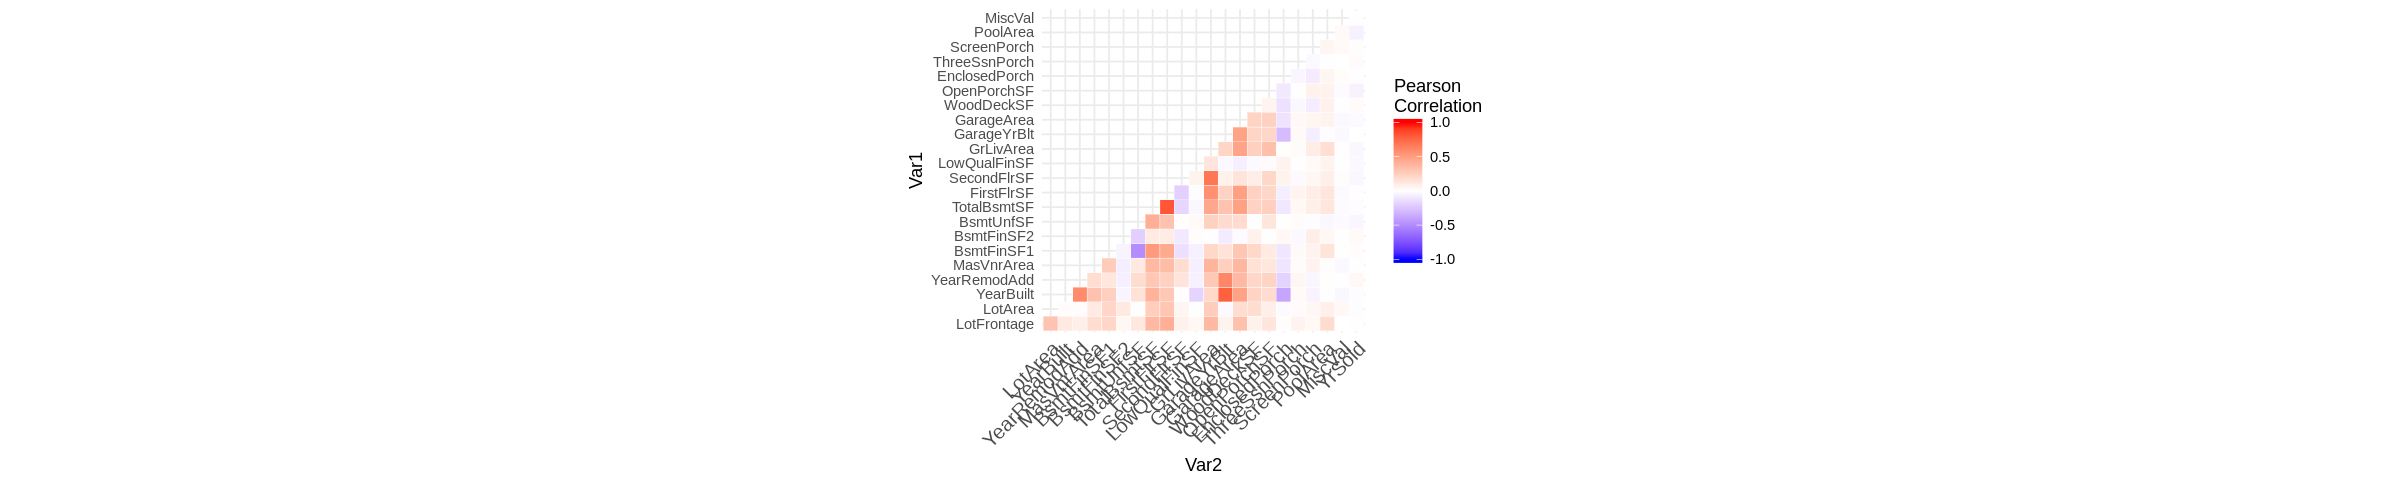

In [14]:
library(reshape2)
cormat = cor(numeric_df)

cormat[lower.tri(cormat)] <- NA
diag(cormat) <- NA

melted_cormat <- melt(cormat, na.rm = T)

library(ggplot2)
ggplot(data = melted_cormat, aes(Var2, Var1, fill = value))+
 geom_tile(color = "white")+
 scale_fill_gradient2(low = "blue", high = "red", mid = "white", 
   midpoint = 0, limit = c(-1,1), space = "Lab", 
   name="Pearson\nCorrelation") +
  theme_minimal()+ 
 theme(axis.text.x = element_text(angle = 45, vjust = 1, 
    size = 12, hjust = 1))+
 coord_fixed()